In [1]:
import json, pickle
import glob

import numpy as np
import pandas as pd

from qiskit import transpile
from qiskit import execute
from qiskit.providers.fake_provider import FakeLima
from qiskit.primitives import Estimator
from qiskit.circuit.random import random_circuit

import torch
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.nn.functional import dropout

from torch_geometric.nn import GCNConv, global_mean_pool, Linear, ChebConv, SAGEConv
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader

from tqdm.notebook import tqdm_notebook
import matplotlib.pyplot as plt
import seaborn as sns

from blackwater.data.loaders.exp_val import CircuitGraphExpValMitigationDataset
from blackwater.data.generators.exp_val import exp_value_generator
from blackwater.data.utils import generate_random_pauli_sum_op
from blackwater.library.ngem.estimator import ngem

from qiskit.quantum_info import random_clifford

import random
from qiskit.circuit.library import HGate, SdgGate
from qiskit.circuit import ClassicalRegister

from blackwater.data.utils import (
    generate_random_pauli_sum_op,
    create_estimator_meas_data,
    circuit_to_graph_data_json,
    get_backend_properties_v1,
    encode_pauli_sum_op,
    create_meas_data_from_estimators
)
from blackwater.data.generators.exp_val import ExpValueEntry
from blackwater.metrics.improvement_factor import improvement_factor, Trial, Problem

from qiskit_aer import AerSimulator, QasmSimulator
from qiskit.providers.fake_provider import FakeMontreal, FakeLima, FakeBelem

from torch_geometric.nn import (
    GCNConv,
    TransformerConv,
    GATv2Conv,
    global_mean_pool,
    Linear,
    ChebConv,
    SAGEConv,
    ASAPooling,
    dense_diff_pool,
    avg_pool_neighbor_x
)
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.utils import to_dense_adj, to_dense_batch

from qiskit import QuantumCircuit
from qiskit.circuit.library import U3Gate, CZGate, PhaseGate, CXGate
from mbd_utils import construct_random_clifford, cal_z_exp, calc_imbalance, cal_all_z_exp, construct_mbl_circuit, generate_disorder, random_clifford_circuit
from gnn import ExpValCircuitGraphModel
from qiskit.quantum_info import Clifford
from qiskit_aer.noise import depolarizing_error, coherent_unitary_error, NoiseModel
from noise_utils import AddNoise, RemoveReadoutErrors

from functools import partial
from qiskit_ibm_runtime import Estimator as RuntimeEstimator
from qiskit.quantum_info import SparsePauliOp

D = {'output': 'mpl', 'fold': -1, 'idle_wires': False}

In [2]:
from qiskit_ibm_provider import IBMProvider
provider = IBMProvider()
backend_ideal = QasmSimulator() # Noiseless
real_backend = provider.get_backend('ibm_algiers')

run_config_ideal = {'shots': 10000, 'backend': backend_ideal, 'name': 'ideal'}
run_config_real_backend = {'shots': 10000, 'backend': real_backend, 'name': 'real_backend'}

In [55]:
backend = FakeLima()
properties = get_backend_properties_v1(backend)

## Local
backend_ideal = QasmSimulator() # Noiseless
backend_noisy = AerSimulator.from_backend(FakeLima()) # Noisy

run_config_ideal = {'shots': 10000, 'backend': backend_ideal, 'name': 'ideal'}
run_config_noisy = {'shots': 10000, 'backend': backend_noisy, 'name': 'noisy'}

num_qubit = 4

In [84]:
from qiskit.transpiler.exceptions import TranspilerError
import scipy

def generate_data(generating_func, two_q_gate_depths, save_path: str, n_entries_per_file: int, run_config_n, seed, h=1):
    np.random.seed(seed)
    for depth in two_q_gate_depths:
        Js = np.random.uniform(0, h, size=n_entries_per_file)
        bases = np.random.choice(list('XYZ'), size=n_entries_per_file)

        entries = []

        for i in tqdm_notebook(range(n_entries_per_file)):
            success = False
            while not success:
                try:
                    circuit = generating_func(num_steps=depth, J=Js[i], basis=bases[i])
                    success = True
                except (scipy.linalg.LinAlgError, TranspilerError, np.linalg.LinAlgError) as e:
                    print(f"Ran into an error:, {e}")
                    Js[i] = 0.1

            job_ideal = execute(circuit, **run_config_ideal)

            counts_ideal = job_ideal.result().get_counts()

            ideal_exp_val = cal_z_exp(counts_ideal)

            to_append = dict()
            to_append['circuit'] = circuit
            to_append['J'] = Js[i]
            to_append['basis'] = bases[i]
            to_append['ideal_exp_val'] = ideal_exp_val
            entries.append(to_append)

        path = f"{save_path}/step_{depth:02d}.pk"
        with open(path, "wb") as f:
            pickle.dump(entries, f)

In [85]:
from qiskit.circuit import Parameter

class IsingModel:

    class Options(dict):
        def __init__(self, *args, **kwargs):
            super().__init__()
            self['nq'] = 4
            self['h'] = 1
            self['J'] = 0.15
            self['dt'] = 1/4
            self['depth'] = 15
            self.update(*args, **kwargs)

        def config_4q_paper(self):
            self['h'] = 1
            self['J'] = 0.15
            self['dt'] = 1/4*2

        def config_10q_paper(self):
            self['h'] = 1
            self['J'] = 0.5236
            self['dt'] = 1/4

    @classmethod
    def apply_quantum_circuit_layer(cls, qc: QuantumCircuit, ops: 'IsingModel.Options'):
        allq = list(range(ops['nq']))

        qc.rx(2*ops['h']*ops['dt'], allq)

        qc.barrier()
        for q0 in allq[0::2]:
            q1 = q0+1
            qc.cx(q0,q1)
        qc.rz(-2*ops['J']*ops['dt'], allq[1::2])
        for q0 in allq[0::2]:
            q1 = q0+1
            qc.cx(q0,q1)

        qc.barrier()
        for q0 in allq[1:-2:2]:
            q1 = q0+1
            qc.cx(q0,q1)
        qc.rz(-2*ops['J']*ops['dt'], allq[2:-1:2])
        for q0 in allq[1:-2:2]:
            q1 = q0+1
            qc.cx(q0,q1)
        qc.barrier()

    @classmethod
    def make_quantum_circuit(cls, ops: 'IsingModel.Options'):
        qc = QuantumCircuit(ops['nq'])
        allq = list(range(ops['nq']))

        for step in range(ops['depth']):
            cls.apply_quantum_circuit_layer(qc, ops)

        if ops['measure_basis'] == 'Z':
            pass
        elif  ops['measure_basis'] == 'X':
            qc.h(allq)
        elif  ops['measure_basis'] == 'Y':
            qc.sdg(allq)
            qc.h(allq)
        else:
            raise Exception("Must be X Y or Z")
        qc.measure_all()

        return qc

    @classmethod
    def make_circs_sweep(cls, ops, num_steps, measure_basis):
        ops['measure_basis'] = measure_basis
        ops['depth'] = num_steps
        qc = cls.make_quantum_circuit(ops)
        qc.metadata = {}
        qc.metadata['measure_basis'] = measure_basis
        qc.metadata['depth'] = num_steps
        return qc

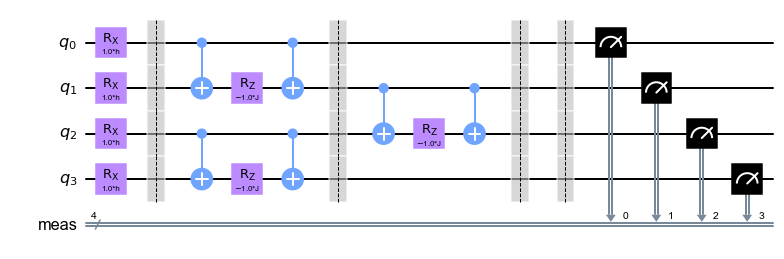

In [86]:
cls = IsingModel
ops = cls.Options()
ops.config_4q_paper()
ops.update({'J': Parameter('J'), 'h': Parameter('h')})
qc = cls.make_circs_sweep(ops, 1, 'Z'), list(range(4))
qc[0].draw('mpl', fold=-1)

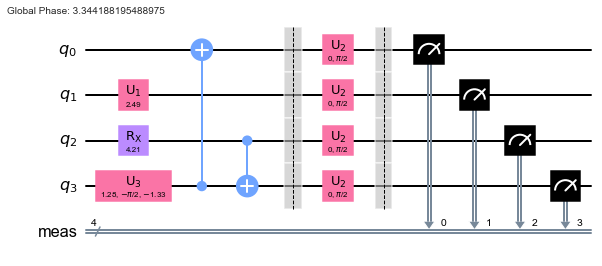

In [87]:
from qiskit.quantum_info import random_statevector
from qiskit.circuit.library import RYGate, RXGate, RZGate, CXGate
from qiskit import QuantumRegister

def construct_ising_circuit_random_init(J, basis, num_steps):
    cls = IsingModel
    ops = cls.Options()
    ops.config_4q_paper()
    ops.update({'J': J})
    qc_init = QuantumCircuit.from_qasm_str('OPENQASM 2.0;\ninclude "qelib1.inc";\nqreg q[4];\nrz(0.0007186381718527407) q[1];\nrz(2.4917901988569855) q[1];\nrz(3.3854853863523835) q[3];\nrx(1.2846113715328817) q[3];\ncx q[3],q[0];\nrx(4.212671608894216) q[2];\ncx q[2],q[3];\n')
    qc_init.barrier()
    qc = qc_init.compose(cls.make_circs_sweep(ops, num_steps, basis), list(range(4)))
    return qc

J = 0.15
basis = np.random.choice(list('XYZ'))
random_ising = construct_ising_circuit_random_init(J, basis, 0)
trans_circuit = transpile(random_ising, backend=backend_ideal, optimization_level=3)
trans_circuit.draw('mpl', fold=-1)

In [88]:
from qiskit.transpiler.passes import RemoveBarriers
def construct_random_ising_func_random_init_real_backend(num_steps, be, J, basis):
    random_ising = construct_ising_circuit_random_init(J, basis, num_steps)
    random_ising = RemoveBarriers()(random_ising)
    trans_circuit = transpile(random_ising, backend=be, optimization_level=3, initial_layout=[0, 1, 2, 3])
    return trans_circuit

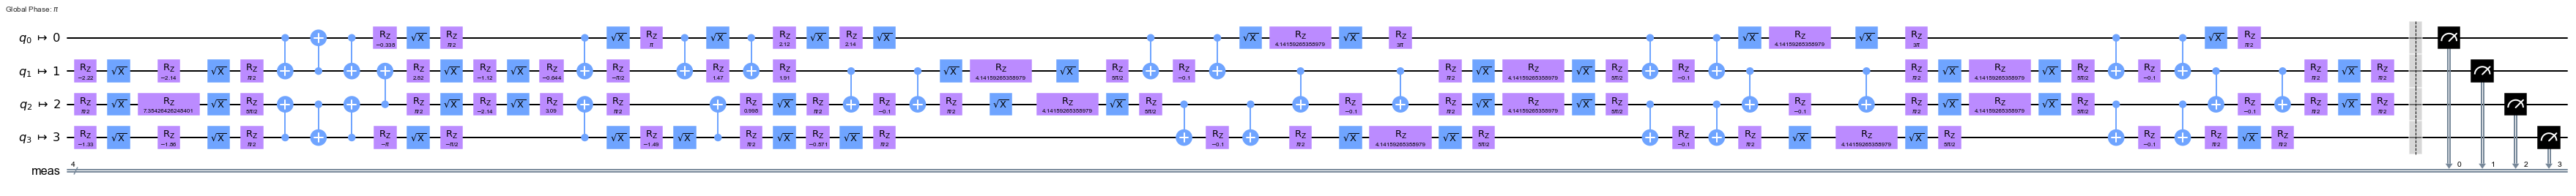

In [89]:
construct_random_ising_func_random_init_real_backend(4, real_backend, 0.1, 'X').draw(**D)

In [90]:
steps = list(range(10))
generate_data(partial(construct_random_ising_func_random_init_real_backend, be=real_backend), steps, './data/ising_init_from_qasm_hardware/train', 300, run_config_n=None, seed=0)

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

Ran into an error:, eig algorithm (geev) did not converge (only eigenvalues with order >= 2 have converged)


  0%|          | 0/300 [00:00<?, ?it/s]

Ran into an error:, eig algorithm (geev) did not converge (only eigenvalues with order >= 2 have converged)


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

Ran into an error:, eig algorithm (geev) did not converge (only eigenvalues with order >= 2 have converged)


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

In [91]:
steps = list(range(10))
generate_data(partial(construct_random_ising_func_random_init_real_backend, be=real_backend), steps, './data/ising_init_from_qasm_hardware/val', 300, run_config_n=None, seed=1)

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

Ran into an error:, eig algorithm (geev) did not converge (only eigenvalues with order >= 2 have converged)


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

Ran into an error:, eig algorithm (geev) did not converge (only eigenvalues with order >= 2 have converged)


  0%|          | 0/300 [00:00<?, ?it/s]

In [92]:
import os
from tqdm.notebook import tqdm

def load_circuits(data_dir, filename=None, f_ext='.pk'):
    circuits = []
    if filename is None:
        data_files = sorted([os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.endswith(f_ext)])
    else:
        data_files = sorted([os.path.join(data_dir, f) for f in [filename]])
    print(data_files)
    for data_file in data_files:
        for entry in pickle.load(open(data_file, 'rb')):
            circuits.append(entry['circuit'])
    return circuits

In [93]:
root1 = './data/ising_init_from_qasm_hardware/train'
root2 = './data/ising_init_from_qasm_hardware/val'
all_circuits = load_circuits(root1)
all_circuits.extend(load_circuits(root2))

['./data/ising_init_from_qasm_hardware/train/step_00.pk', './data/ising_init_from_qasm_hardware/train/step_01.pk', './data/ising_init_from_qasm_hardware/train/step_02.pk', './data/ising_init_from_qasm_hardware/train/step_03.pk', './data/ising_init_from_qasm_hardware/train/step_04.pk', './data/ising_init_from_qasm_hardware/train/step_05.pk', './data/ising_init_from_qasm_hardware/train/step_06.pk', './data/ising_init_from_qasm_hardware/train/step_07.pk', './data/ising_init_from_qasm_hardware/train/step_08.pk', './data/ising_init_from_qasm_hardware/train/step_09.pk']
['./data/ising_init_from_qasm_hardware/val/step_00.pk', './data/ising_init_from_qasm_hardware/val/step_01.pk', './data/ising_init_from_qasm_hardware/val/step_02.pk', './data/ising_init_from_qasm_hardware/val/step_03.pk', './data/ising_init_from_qasm_hardware/val/step_04.pk', './data/ising_init_from_qasm_hardware/val/step_05.pk', './data/ising_init_from_qasm_hardware/val/step_06.pk', './data/ising_init_from_qasm_hardware/val/s

In [94]:
def shuffle_list_inplace(input_list):
    index_order = list(range(len(input_list)))
    import random

    random.seed(42)
    random.shuffle(index_order)
    input_list[:] = np.array(input_list, dtype=QuantumCircuit)[index_order]
    return index_order

def unshuffle_list(shuffled_list, index_order):
    unshuffled_list = [None] * len(shuffled_list)
    for i, index in enumerate(index_order):
        unshuffled_list[index] = shuffled_list[i]
    return unshuffled_list

In [103]:
import warnings
warnings.filterwarnings('ignore')
index_order = shuffle_list_inplace(all_circuits)
all_circuits = unshuffle_list(all_circuits, index_order)

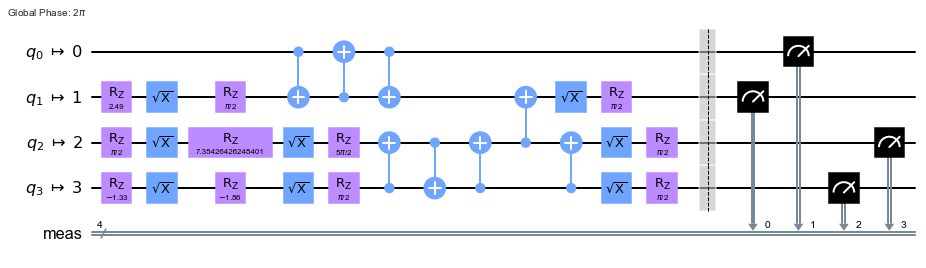

In [104]:
all_circuits[210].draw(**D)

In [ ]:
index_order = shuffle_list_inplace(all_circuits)
print(index_order)

with open('./data/ising_init_from_qasm_hardware/shuffled/index_order.json', 'w') as file:
    json.dump(index_order, file)

In [116]:
bs = 50
for i, start_ind in enumerate(range(0, len(all_circuits), bs)):
    circuit_batch = all_circuits[start_ind:start_ind+bs]
    index_order_batch = index_order[start_ind:start_ind+bs]
    to_save = {
        'circuit_batch': circuit_batch,
        'index_order_batch': index_order_batch,
        'start_ind':start_ind,
        'batch_size': bs,
    }
    with open(f'./data/ising_init_from_qasm_hardware/shuffled/batch_{i:02d}.pk', 'wb') as file:
        pickle.dump(to_save, file)

In [132]:
from qiskit_ibm_runtime import QiskitRuntimeService, Session, Estimator, Options

service = QiskitRuntimeService()
options = Options()
options.resilience_level = 2
options.optimization_level = 1
options.execution.shots = 10000
options.resilience.noise_factors = (1, 3)
options.resilience.noise_amplifier = 'TwoQubitAmplifier'
options.resilience.extrapolator = 'LinearExtrapolator'

runtime_estimator = RuntimeEstimator(session=Session(service=service, backend=real_backend.name), options=options)

In [133]:
obs_list = ['ZIII', 'IZII', 'IIZI', 'IIIZ']

def form_all_qubit_observable(observable, measurement_qubits, total_num_qubits):
    """Input observable in non-endian, output observable in endian"""
    assert len(observable) == len(measurement_qubits)
    converted_obs = list('I' * total_num_qubits)
    for qubit, basis in zip(measurement_qubits, list(observable)):
        converted_obs[qubit] = basis
    return ''.join(converted_obs)[::-1]

def get_measurement_qubits(qc, num_measured_qubit):
    measurement_qubits = []
    for measurement in range(num_measured_qubit - 1, -1, -1):
        measurement_qubits.append(qc.data[-1 - measurement][1][0].index)
    return measurement_qubits

In [138]:
def load_circuits(data_dir, filename=None, f_ext='.pk'):
    if filename is None:
        data_files = sorted([os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.endswith(f_ext)])
    else:
        data_files = sorted([os.path.join(data_dir, f) for f in [filename]])
    print(data_files)
    for data_file in data_files:
        circuits = pickle.load(open(data_file, 'rb'))['circuit_batch']
    return circuits

In [139]:
root = './data/ising_init_from_qasm_hardware/shuffled'
for i in tqdm(range(120)):
    circuits = load_circuits(root, f'batch_{i:02d}.pk')

    padded_obs_all_circs = []
    for trans_circuit in circuits:
        padded_obs_all_circs += [SparsePauliOp(form_all_qubit_observable(obs, get_measurement_qubits(trans_circuit, 4), 27)) for obs in obs_list]
        print(padded_obs_all_circs[-4:])

    circs_to_submit = []
    for circ in circuits:
        circ.remove_final_measurements()
        circs_to_submit.extend([circ]*len(obs_list))

    job = runtime_estimator.run(
        circuits=circs_to_submit,
        observables=padded_obs_all_circs
    )
    print(job.job_id())

    to_save = {
        'job_id': job.job_id(),
        'shots': 10000,
        'batch': i,
        'backend': real_backend.name,
    }
    with open(root+f'/batch_{i:02d}.json', 'w') as file:
        json.dump(to_save, file)

  0%|          | 0/120 [00:00<?, ?it/s]

['./data/ising_init_from_qasm_hardware/shuffled/batch_00.pk']
[SparsePauliOp(['IIIIIIIIIIIIIIIIIIIIIIIIIIZ'],
              coeffs=[1.+0.j]), SparsePauliOp(['IIIIIIIIIIIIIIIIIIIIIIIIIZI'],
              coeffs=[1.+0.j]), SparsePauliOp(['IIIIIIIIIIIIIIIIIIIIIIIIZII'],
              coeffs=[1.+0.j]), SparsePauliOp(['IIIIIIIIIIIIIIIIIIIIIIIZIII'],
              coeffs=[1.+0.j])]
[SparsePauliOp(['IIIIIIIIIIIIIIIIIIIIIIIIIIZ'],
              coeffs=[1.+0.j]), SparsePauliOp(['IIIIIIIIIIIIIIIIIIIIIIIIIZI'],
              coeffs=[1.+0.j]), SparsePauliOp(['IIIIIIIIIIIIIIIIIIIIIIIIZII'],
              coeffs=[1.+0.j]), SparsePauliOp(['IIIIIIIIIIIIIIIIIIIIIIIZIII'],
              coeffs=[1.+0.j])]
[SparsePauliOp(['IIIIIIIIIIIIIIIIIIIIIIIIIIZ'],
              coeffs=[1.+0.j]), SparsePauliOp(['IIIIIIIIIIIIIIIIIIIIIIIIIZI'],
              coeffs=[1.+0.j]), SparsePauliOp(['IIIIIIIIIIIIIIIIIIIIIIIIZII'],
              coeffs=[1.+0.j]), SparsePauliOp(['IIIIIIIIIIIIIIIIIIIIIIIZIII'],
              coeff